Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt 
from IPython import display

In [2]:
def plot_multiple_images(images, n_cols = None):
  '''Visualize fake images'''
  display.clear_output(wait=False)
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1) #get rid of the channel axis if it's 1.

  plt.figure(figsize=(n_cols, n_rows))

  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")


##Get the data and prepare

In [3]:
(X_train, _), _ = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32) / 255. 

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
BATCH_SIZE = 128 

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

##Build the Generator

In [5]:
#declare the shape of the noise input 
random_normal_dimensions = 32 

#build the generator model 
generator = tf.keras.models.Sequential([
                                        keras.layers.Dense(64, activation="selu", input_shape =[random_normal_dimensions]),
                                        keras.layers.Dense(128, activation="selu"), 
                                        keras.layers.Dense(784, activation="sigmoid"),
                                        keras.layers.Reshape([28,28])

])

**Generate and plot 16 random noise images. These will look like MNIST digits on the GAN is trained**

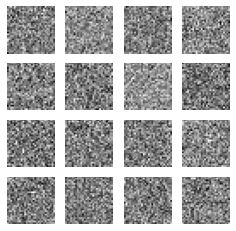

In [6]:
#generate a batch of 16 random vectors with random_normal_dimensions
test_noise = tf.random.normal([16, random_normal_dimensions])

#feed the noise into the generator. 
test_image = generator(test_noise)

#display the fake images that the generator generated from noise. 
plot_multiple_images(test_image, n_cols=4)

##Build the discriminator

In [7]:
discriminator = keras.models.Sequential([
                                         
                                         keras.layers.Flatten(input_shape = [28,28]),
                                         keras.layers.Dense(128, activation="selu"), 
                                         keras.layers.Dense(64, activation="selu"),
                                         keras.layers.Dense(1, activation="sigmoid")
])

#Generator + Discriminator = GAN

In [8]:
gan = keras.models.Sequential([generator, discriminator])

#Model Configuration

In [9]:
#Discriminator is just a binary classifier so it has binary loss.
discriminator.compile(loss = "binary_crossentropy", optimizer="rmsprop", metrics="accuracy") 
discriminator.trainable = False 

#Since the final part of the entire GAN is discriminator, config it with the same loss.
gan.compile(loss="binary_crossentropy", optimizer="rmsprop") 

#Train the model

In [16]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
  """ Defines the two-phase training loop of the GAN
  Args:
    gan -- the GAN model which has the generator and discriminator
    dataset -- the training set of real images
    random_normal_dimensions -- dimensionality of the input to the generator
    n_epochs -- number of epochs
  """

  #get the models.
  generator, discriminator = gan.layers 

  #start the custom training loop. 
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))

    #In each step (batch)
    for real_images in dataset:

      #infer batch_size from the training batch.
      batch_size = real_images.shape[0]

      ''' PHASE 1 -- TRAINING THE DISCRIMINATOR'''

      #get the noise
      noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

      #feed the noise into the generator to get fake images.
      fake_images = generator(noise)

      #combine the fake and real images to feed into the discriminator.
      mixed_images = tf.concat([fake_images, real_images], axis=0)

      #create labels for the discriminator. Since we're training the discriminator in this phase, the labels reflect truth.
      mixed_labels = tf.constant([0.] * batch_size + [1.] * batch_size) # notice that the order matters.

      #discriminator is traineble on this phase 1. 
      discriminator.trainable = True 

      #train the discriminator on this batch. 
      discriminator.train_on_batch(mixed_images, mixed_labels)

      ''' PHASE 2 -- TRAINING THE GENERATOR'''

      #generate some noise.
      noise = tf.random.normal([batch_size, random_normal_dimensions])
      
      #label all generated images real (THIS IS HOW GAN IS ADVERSARIAL, IT'S TRYING TO 'TRICK' THE DISCRIMINATOR INTO BELIEVING ALL GENERATED DATA IS REAL)
      fake_labels = tf.constant([1.] * batch_size)

      #freeze the discriminator so that this fake labeling does not confuse it (change its weights). 
      discriminator.trainable = False 

      #Train the entire GAN on the noise with the labels all set to true.
      gan.train_on_batch(noise, fake_labels)

    plot_multiple_images(fake_images, 8)
    plt.show()

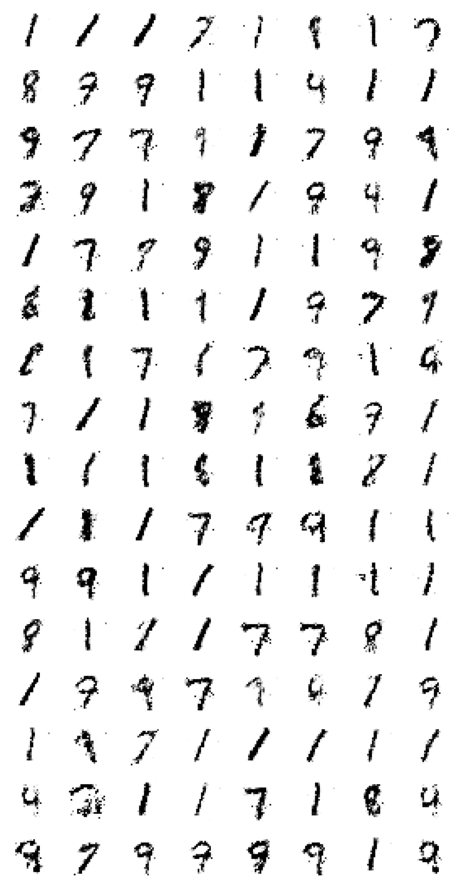

In [17]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=50)